In [1]:
##The code is edited in Jupyter. Thanks for the research map from Capital One and for the data from New York City Taxi and Limousine commission
## Import library and download the csv file
import pandas as pd
import urllib.request ## for downloading the file
import numpy as np
import matplotlib
from matplotlib import pyplot as plt ##These two are for drawing graphs
import math 
import statsmodels.api as sm ## for linear regression
import scipy.stats as stats ## for statistical test

In [2]:
##Download raw data set to current working directory
url="https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
download=urllib.request.urlretrieve(url,"green_tripdata_2015-09.csv")
download

('green_tripdata_2015-09.csv', <http.client.HTTPMessage at 0x2636b400e48>)

In [3]:
rawGreen=pd.read_csv("green_tripdata_2015-09.csv")

In [4]:
## Report the number of rows of columns
rawGreen.shape
## The result shows that there are 1,494,926 records with 21 variables

(1494926, 21)

In [5]:
##define function to reject outlier data points
def reject_outliers(data, m=6):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

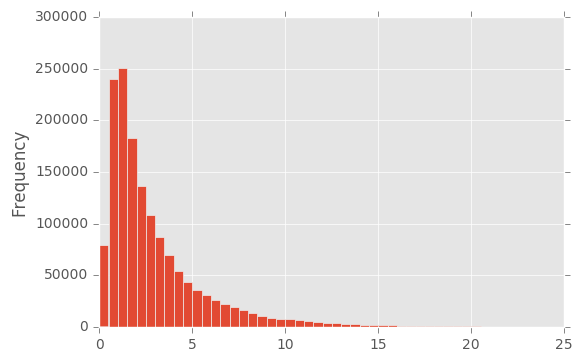

In [6]:
%matplotlib inline
plt.style.use('ggplot')
tripDistance=rawGreen.Trip_distance
tripDistanceNoOut=reject_outliers(tripDistance)##omit the outliers
tripDistanceNoOut.plot.hist(bins=np.arange(0, max(tripDistanceNoOut) , 0.5))

The total are in manhattan where green cab can run is 96E street to 110W street which is approximately a 2.5 mile * 0.8 mile square, plus LGA and JFK if booked
There are 15 steets and 14 avenues in this area, meaning the total length of roads in this area is 2.5*15+0.8*14=48.7 miles
The max distance in Manhattan should be 2.5+0.8=3.3 miles take 4 to consider some specific situation
The MAX distance from LGA to this area is 9.6 miles and MIN distance is 7.4 miles
The MAX distance from JFK is 20 mile and min distance is 18 miles

--->Around (7.5+24+25+18+13+11+8+7)/149=77% rentals happened on Manhattan  while 10% happend between airport and Manhattan

In [7]:
## Get prepared for the time needed in following calculation
    ##This chunk may take as long as 5 mins to run
hourStart=[None]*(rawGreen.shape[0])
minStart=[None]*(rawGreen.shape[0])
secStart=[None]*(rawGreen.shape[0])
hourEnd=[None]*(rawGreen.shape[0])
minEnd=[None]*(rawGreen.shape[0])
secEnd=[None]*(rawGreen.shape[0])
startTime=rawGreen.lpep_pickup_datetime
endTime=rawGreen.Lpep_dropoff_datetime
for i in range(0,rawGreen.shape[0]):
    hourStart[i]=startTime[i][11:13]
    minStart[i]=startTime[i][14:16]
    secStart[i]=startTime[i][17:19]
    hourEnd[i]=endTime[i][11:13]
    minEnd[i]=endTime[i][14:16]
    secEnd[i]=endTime[i][17:19]

In [8]:
hourStartPd=pd.DataFrame(hourStart)
hourStartPd.columns=['hourStart']
rawGreenFull=rawGreen.join(hourStartPd)

In [9]:
##Report the mean and median of the trip distance by hour
distanceMean_hour=rawGreenFull.groupby(['hourStart'])['Trip_distance'].mean()
distanceMedian_hour=rawGreenFull.groupby(['hourStart'])['Trip_distance'].median()

In [10]:
distanceMean_hour

hourStart
00    3.115276
01    3.017347
02    3.046176
03    3.212945
04    3.526555
05    4.133474
06    4.055149
07    3.284394
08    3.048450
09    2.999105
10    2.944482
11    2.912015
12    2.903065
13    2.878294
14    2.864304
15    2.857040
16    2.779852
17    2.679114
18    2.653222
19    2.715597
20    2.777052
21    2.999189
22    3.185394
23    3.191538
Name: Trip_distance, dtype: float64

In [11]:
distanceMedian_hour

hourStart
00    2.20
01    2.12
02    2.14
03    2.20
04    2.36
05    2.90
06    2.84
07    2.17
08    1.98
09    1.96
10    1.92
11    1.88
12    1.89
13    1.84
14    1.83
15    1.81
16    1.80
17    1.78
18    1.80
19    1.85
20    1.90
21    2.03
22    2.20
23    2.22
Name: Trip_distance, dtype: float64

In the following part I use longitude to identify whether a trip is from/to the airport
From Google map, I define the bound is -73.9

In [12]:
##Get prepared for the longitude
pickUpLong=rawGreenFull.Pickup_longitude
dropOffLong=rawGreenFull.Dropoff_longitude
##Identify whether it originate or ternimate at airport
whetherAirport=[None]*(rawGreen.shape[0])# if it start/end at the airport this value is 1 or the value is 0
for i in range(0,rawGreen.shape[0]):
    if (pickUpLong[i]+73.9)*(dropOffLong[i]+73.9)<0:
        whetherAirport[i]=1
    else:
        whetherAirport[i]=0

In [13]:
whetherAirportPd=pd.DataFrame(whetherAirport)
whetherAirportPd.columns=['whetherAirport']
numAirportTrans=rawGreen.shape[0]*whetherAirportPd.mean()
numAirportTrans
## It shows that there are 161446 transaction startedd/ended at the airports, accounting for 11% of the total transaction

whetherAirport    161446.0
dtype: float64

In [14]:
GreenWAirport=rawGreenFull.join(whetherAirportPd) ## Combine the raw data with new variable
## with this, we can calculate the average of (passenger count, trip distance,fare amount, tip amount(tip ratio) by category )

In [16]:
##Derive the percentage of tip tipPercentage=Tip_amount/Total_amount
tipPercentage=GreenWAirport.Tip_amount.div(GreenWAirport.Total_amount)
tipPercentage=pd.DataFrame(tipPercentage)
tipPercentage.columns=['tipPercentage']
GreenWAirportWTip=GreenWAirport.join(tipPercentage)## Combine with new Variable

In [18]:
distance_airport=GreenWAirport.groupby(['whetherAirport'])['Trip_distance'].mean()
totalFare_airport=GreenWAirport.groupby(['whetherAirport'])['Total_amount'].mean()
passengerCount_airport=GreenWAirport.groupby(['whetherAirport'])['Passenger_count'].mean()
tipPercentage_airport=GreenWAirportWTip.groupby(['whetherAirport'])['tipPercentage'].mean()
##In this chunk I want to derive the different speed between in Mahattan and Airport, but something wrong with calculation the trip time

In [19]:
## Define whether a trip is in late night (23p.m.-06a.m.)
whetherNight=[None]*(rawGreen.shape[0])# if it is late night this value is 1 or the value is 0
for i in range(0,rawGreen.shape[0]):
    if (hourStart[i]=='23'or hourStart[i]=='00'or hourStart[i]=='01' or hourStart[i]=='02' or hourStart[i]=='03' or hourStart[i]=='04' or hourStart[i]=='05') or hourStart[i]=='06':
        whetherNight[i]=1
    else:
        whetherNight[i]=0

In [20]:
whetherNightPd=pd.DataFrame(whetherNight)
whetherNightPd.columns=['whetherNight']
GreenWAirportWTipWNight=GreenWAirportWTip.join(whetherNightPd)##Combine with new variable

In [21]:
##try to find out whether there are significant difference whether in late night
distance_night=GreenWAirportWTipWNight.groupby(['whetherNight'])['Trip_distance'].mean()
totalFare_night=GreenWAirportWTipWNight.groupby(['whetherNight'])['Total_amount'].mean()
passengerCount_night=GreenWAirportWTipWNight.groupby(['whetherNight'])['Passenger_count'].mean()
tipPercentage_night=GreenWAirportWTipWNight.groupby(['whetherNight'])['tipPercentage'].mean()
distance_night
totalFare_night
passengerCount_night
tipPercentage_night

whetherNight
0    0.066309
1    0.067317
Name: tipPercentage, dtype: float64

In [22]:
##Get prepared to calculate duration of each ride
minStartPd=pd.DataFrame(minStart)
minStartPd.columns=['minStart']
secStartPd=pd.DataFrame(secStart)
secStartPd.columns=['secStart']
hourEndPd=pd.DataFrame(hourEnd)
hourEndPd.columns=['hourEnd']
minEndPd=pd.DataFrame(minEnd)
minEndPd.columns=['minEnd']
secEndPd=pd.DataFrame(secEnd)
secEndPd.columns=['secEnd']

In [23]:
## Calculate time each ride took (in minutes)
startTimeInMin=[None]*(rawGreen.shape[0])
endTimeInMin=[None]*(rawGreen.shape[0])
timeLasting=[None]*(rawGreen.shape[0])
for i in range(0,rawGreen.shape[0]):
    startTimeInMin[i]=(int(hourStart[i])*60+int(minStart[i])+int(secStart[i])/60)
    endTimeInMin[i]=int(hourEnd[i])*60+int(minEnd[i])+int(secEnd[i])/60
    timeLasting[i]=endTimeInMin[i]-startTimeInMin[i]

In [24]:
timeLastingPd=pd.DataFrame(timeLasting)
timeLastingPd.columns=['timeLasting']
timeLastingPd[timeLastingPd<0]=math.inf  ##deal with outlier point set it to inf so that the corresponding speed will be 0

In [25]:
GreenWAirportWTipWNightWTime=GreenWAirportWTipWNight.join(timeLastingPd)## combine the new variable

In [26]:
##Derive speed for each ride
speed=GreenWAirportWTipWNightWTime.Trip_distance.div(GreenWAirportWTipWNightWTime.timeLasting)*60
speedPd=pd.DataFrame(speed)
speedPd=speedPd[speedPd<100] ## omit those outliers
speedPd.columns=['speed']
GreenWAirportWTipWNightWTimeWSpeed=GreenWAirportWTipWNightWTime.join(speedPd)

In [27]:
##Introduce the variable to identify different week
date=[None]*(rawGreen.shape[0])
for i in range(0,rawGreen.shape[0]):
    date[i]=startTime[i][8:10]
    ## In this case we suppose one week begin from Monday
week=[None]*(rawGreen.shape[0])
for i in range(0,rawGreen.shape[0]):
    if date[i]=='01' or date[i]=='02' or date[i]=='03' or date[i]=='04' or date[i]=='05' or date[i]=='06' :
        week[i]=1
    elif date[i]=='07' or date[i]=='08' or date[i]=='09' or date[i]=='10' or date[i]=='11' or date[i]=='12' or date[i]=='13' :
        week[i]=2
    elif date[i]=='14' or date[i]=='15' or date[i]=='16' or date[i]=='17' or date[i]=='18' or date[i]=='19' or date[i]=='20' :
        week[i]=3
    elif date[i]=='21' or date[i]=='22' or date[i]=='23' or date[i]=='24' or date[i]=='25' or date[i]=='26' or date[i]=='27' :
        week[i]=4
    elif date[i]=='28' or date[i]=='29' or date[i]=='30' :
        week[i]=5

In [28]:
weekPd=pd.DataFrame(week)
weekPd.columns=['week']
GreenWAirportWTipWNightWTimeWSpeedWWeek=GreenWAirportWTipWNightWTimeWSpeed.join(weekPd)## Combine the new Variable

The following chunks will try to find the relationship between tip rate and other variables.

In [29]:
##deal with nan and inf
GreenWAirportWTipWNightWTimeWSpeedWWeek.replace([np.inf, -np.inf], np.nan)
greenFinal=GreenWAirportWTipWNightWTimeWSpeedWWeek.fillna(method='backfill')
## do linear regrssion between tipPercentage---Passenger_count, Trip_distance, Fare_amount, whetherNight, whetherAirport, speed
X=greenFinal[['Passenger_count','Trip_distance','Fare_amount','whetherNight','whetherAirport','speed']]
Y=greenFinal['tipPercentage']
X = sm.add_constant(X)
est = sm.OLS(Y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          tipPercentage   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     4336.
Date:                Sun, 05 Mar 2017   Prob (F-statistic):               0.00
Time:                        06:54:43   Log-Likelihood:             1.5121e+06
No. Observations:             1494926   AIC:                        -3.024e+06
Df Residuals:                 1494919   BIC:                        -3.024e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const               0.0539      0.000    254.216      0.000         0.053     0.054
Passenger_count     0.0001   6.93e-05      1.879      0.060      -5.6e-06     0.000
Trip_distance       0.0028   4.95e-05     57.429      0.000         0.003     0.003
Fare_amount         0.0002   1.36e-05     13.702      0.000         0.000     0.000
whetherNight       -0.0004      0.000     -2.389      0.017        -0.001 -7.47e-05
whetherAirport     -0.0270      0.000   -108.356      0.000        -0.028    -0.027
speed               0.0004   1.42e-05     26.240      0.000         0.000     0.000
==============================================================================
Omnibus:                   450107.470   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2364188.606
Skew:                           1.360   Prob(JB):                         0.00
Kurtosis:                       8.527   Cond. No.                         72.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
##This is my second attempt
X1=greenFinal[['Passenger_count','Trip_distance','Fare_amount','whetherAirport','speed']]
Y1=greenFinal['tipPercentage']
X = sm.add_constant(X)
est = sm.OLS(Y1, X1).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          tipPercentage   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 1.564e+05
Date:                Sun, 05 Mar 2017   Prob (F-statistic):               0.00
Time:                        06:55:20   Log-Likelihood:             1.4803e+06
No. Observations:             1494926   AIC:                        -2.961e+06
Df Residuals:                 1494921   BIC:                        -2.960e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Passenger_count     0.0080   6.33e-05    126.980      0.000         0.008     0.008
Trip_distance      -0.0017   4.72e-05    -36.798      0.000        -0.002    -0.002
Fare_amount         0.0017   1.26e-05    132.898      0.000         0.002     0.002
whetherAirport     -0.0314      0.000   -123.390      0.000        -0.032    -0.031
speed               0.0029   1.01e-05    287.797      0.000         0.003     0.003
==============================================================================
Omnibus:                   438139.673   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2563426.334
Skew:                           1.286   Prob(JB):                         0.00
Kurtosis:                       8.877   Cond. No.                         71.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
##Show the average speed grouped by hours
speed_hour=greenFinal.groupby(['hourStart'])['speed'].mean()
speed_hour

hourStart
00    14.545004
01    14.786231
02    14.990236
03    15.367228
04    16.158513
05    17.916235
06    16.946160
07    13.427496
08    12.249486
09    12.505732
10    12.478612
11    12.197977
12    12.085502
13    11.996609
14    11.506909
15    11.137964
16    10.897975
17    10.887755
18    11.465511
19    12.019695
20    12.706014
21    13.556599
22    14.017463
23    11.300575
Name: speed, dtype: float64

The following chunks will check whether the average speed of different weeks in September are the same

In [32]:
speedWeek1=greenFinal.speed[greenFinal.week==1]
speedWeek2=greenFinal.speed[greenFinal.week==2]
speedWeek3=greenFinal.speed[greenFinal.week==3]
speedWeek4=greenFinal.speed[greenFinal.week==4]
speedWeek5=greenFinal.speed[greenFinal.week==5]
stats.f_oneway(speedWeek1, speedWeek2, speedWeek3, speedWeek4, speedWeek5)

F_onewayResult(statistic=843.14106813529077, pvalue=0.0)

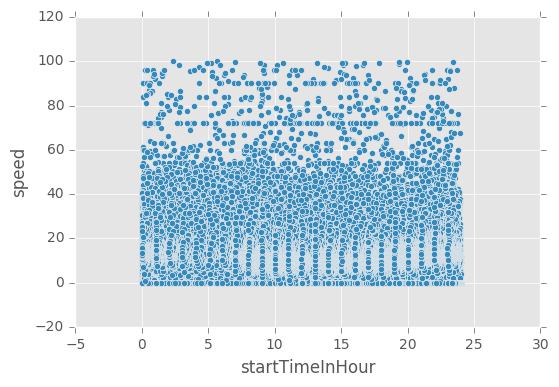

In [33]:
##Plot the scatter of speed with different time
startTimeInMinPd=pd.DataFrame(startTimeInMin)
startTimeInHourPd=startTimeInMinPd.div(60)
startTimeInHourPd.columns=['startTimeInHour']
speedStartTime=startTimeInHourPd.join(speedPd)
speedStartTime.head()
matplotlib.style.use('ggplot') 
speedStartTime.plot.scatter(x='startTimeInHour', y='speed')

The following chunk shows the fitting quadratic function between average speed an different hours of a day

In [34]:
hour = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]) ## These data is from speed_hour
speed = np.array([14.545004,14.786231,14.990236,15.367228,16.158513,17.916235,16.94616,13.427496,12.249486,12.505732,12.478612,12.197977,12.085502,11.996609,11.506909,11.137964,10.897975,10.887755,11.465511,12.019695,12.706014,13.556599,14.017463,11.300575])
z1 = np.polyfit(hour, speed, 4)
p1 = np.poly1d(z1)
print(p1)

            4           3          2
-0.0004527 x + 0.02349 x - 0.3806 x + 1.78 x + 13.76
